In [1]:
import requests,tempfile,json
from math import sqrt,pow
from qgis.PyQt.QtCore import QVariant
from qgis.core import QgsVectorLayer,QgsField,QgsFeature
from osgeo import gdal
import numpy as np

#for developing
import geopandas as gpd
import rasterio
from rasterio.plot import show
#import matplotlib.pyplot as plt

<AxesSubplot:>

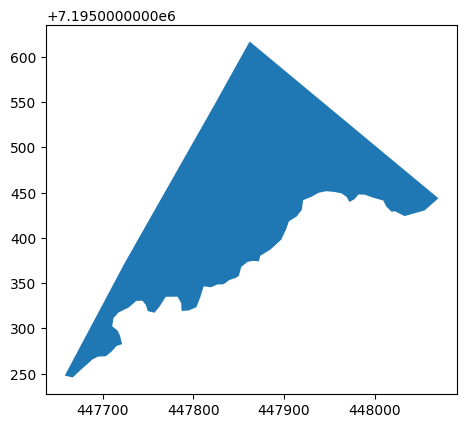

In [2]:
data_example = "data_example\ReTreeT.gpkg"
layer = "cuttingarea"
data_qgis = QgsVectorLayer(data_example+"|layername="+layer,"cutarea","ogr")
data_df = gpd.read_file(data_example,layer = layer)

data_df

data_df.plot()

In [3]:
esri_image = 'https://aineistot.metsakeskus.fi/metsakeskus/rest/services/Vesiensuojelu/DEM/ImageServer'
wms_image = 'https://rajapinnat.metsaan.fi/geoserver/Avoinmetsatieto/CHM_newest/ows?'
wcs_name = 'paituli:luke_dtw_04'
wcs_image = 'https://paituli.csc.fi/geoserver/paituli/wcs?'


In [4]:
def getBboxWmsFormat(in_feat:QgsVectorLayer):
    desc=in_feat.extent()
    x_min=int(desc.xMinimum())
    y_min=int(desc.yMinimum())
    x_max=int(desc.xMaximum())+1
    y_max=int(desc.yMaximum())+1
    srid=str(in_feat.crs().authid())
    exte = str(x_min)+","+str(y_min)+","+str(x_max)+","+str(y_max)
    witdth = x_max - x_min
    height = y_max - y_min
    
    return exte,srid,witdth,height

In [5]:
bb = getBboxWmsFormat(data_qgis)
print (bb)

('447658,7195245,448071,7195618', 'EPSG:3067', 413, 373)


In [7]:
def doEsriParams(input_polygon:QgsVectorLayer):
    bbox = getBboxWmsFormat(input_polygon)
    ss = bbox[0].split(',')
    params = {"bbox":str(round(int(ss[0])-100,-1))+","+str(round(int(ss[1])-100,-1))+","+str(round(int(ss[2])+100,-1))+","+str(round(int(ss[3])+100,-1)),
                "bboxSR":bbox[1],
                "size":str((round(int(ss[2])+100,-1)-round(int(ss[0])-100,-1))/2)+","+str((round(int(ss[3])+100,-1) - round(int(ss[1])-100,-1))/2),
                "imageSR":3067,
                "format":'tiff',
                "pixelType":"F32",
                "noData":-9999,
                "noDataInterpretation":"esriNoDataMatchAny",
                "interpolation":"+RSP_BilinearInterpolation",
                "f":"image"}
    return params
    

In [8]:
def doWmsParams(input_polygon:QgsVectorLayer):
    bbox = getBboxWmsFormat(input_polygon)
    params = {'service':'wms',
          'request':'getMap',
         'bbox':bbox[0],
          'format':'image/geotiff',
          'width':bbox[2],
          'height':bbox[3],
          'layers':'CHM_newest',
          'srs':bbox[1]}
    return params

In [9]:
def doWcsParams(input_polygon:QgsVectorLayer,url,name):
    bbox = getBboxWmsFormat(input_polygon)
    ss = bbox[0].split(',')
    covId = 'paituli:luke_dtw_04'
    version = '2.0.0'
    sset1 = 'E('+ss[0]+','+ss[2]+')'
    sset2 = 'N('+ss[1]+','+ss[3]+')'
    params = {'service':'WCS',
        'request':'GetCoverage',
        'version':version,
        'coverageId':covId}
    url = url+'subset='+sset1+'&subset='+sset2
    
    return url,params

In [10]:
def getWebRasterLayer(input_polygon:QgsVectorLayer,url:str,name:str):
    tempd = tempfile.TemporaryFile()
    tempd = tempd.name+'.tif'
    
    if url.endswith("ImageServer"):
        url = url + "/exportImage?"
        params = doEsriParams(input_polygon)
    elif url.endswith("ows?") or url.endswith("wms?"):
        params = doWmsParams(input_polygon)
    else:
        prep = doWcsParams(input_polygon,url,name)
        params = prep[1]
        url = prep[0]
        

    try:
        respo= requests.get(url,params,allow_redirects=True)
        
        if respo.status_code != 200:
           info = "Cannot connect to data: "+str(url)
           infolevel = 3
        else:
            open(tempd,'wb').write(respo.content)
    
    except:
        info = "Cannot connect to data: "+str(url)
        infolevel = 3
    
        
    try:
        test = gdal.Open(tempd)
        test_b = test.GetRasterBand(1)
        test_a = test_b.ReadAsArray()
        if np.max(test_a) > 1.0:
            info =  "data is ok!"
            infolevel = 1
            del test,test_b,test_a
        else:
           info = "Not able find data from area"
           infolevel = 3
    except:
        info = "Not able find data from area"
        infolevel = 3

    return tempd,info,infolevel

In [11]:
test_esri_image = getWebRasterLayer(data_qgis,esri_image,"")
print (test_esri_image)

('C:\\Users\\mkesala\\AppData\\Local\\Temp\\tmpx7_a6hrw.tif', 'data is ok!', 1)


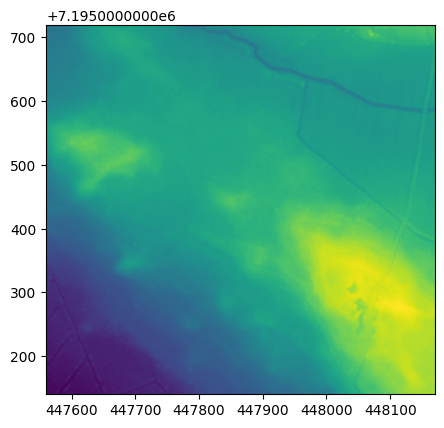

<AxesSubplot:>

In [12]:
test_raster = rasterio.open(test_esri_image[0])
show(test_raster)

('C:\\Users\\mkesala\\AppData\\Local\\Temp\\tmpu8lc0oe_.tif', 'data is ok!', 1)


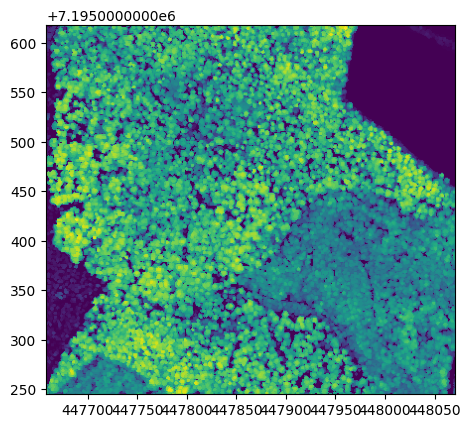

<AxesSubplot:>

In [13]:
test_wms_image = getWebRasterLayer(data_qgis,wms_image,"")
print (test_wms_image)
test_raster = rasterio.open(test_wms_image[0])
show(test_raster)

('C:\\Users\\mkesala\\AppData\\Local\\Temp\\tmp90kvv7rn.tif', 'data is ok!', 1)


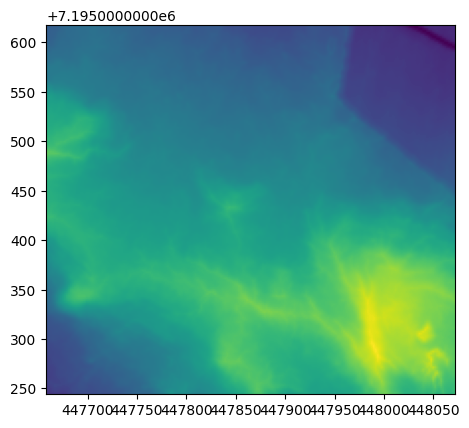

<AxesSubplot:>

In [14]:
test_wcs_image = getWebRasterLayer(data_qgis,wcs_image,wcs_name)
print (test_wcs_image)
test_raster = rasterio.open(test_wcs_image[0])
show(test_raster)

In [15]:
wfs_layer = 'https://avoin.metsakeskus.fi/rajapinnat/v1/gridcell/ows?'
wfs_name = 'gridcell'
wfs_attributes = 'GEOMETRY,GRIDCELLNUMBER,FERTILITYCLASS,LASERHEIGHT,STEMCOUNTPINE,MEANDIAMETERPINE,MEANHEIGHTPINE,STEMCOUNTSPRUCE,MEANDIAMETERSPRUCE,MEANHEIGHTSPRUCE,STEMCOUNTDECIDUOUS,MEANDIAMETERDECIDUOUS,MEANHEIGHTDECIDUOUS'

esri_feature = 'https://paikkatieto.ymparisto.fi/arcgis/rest/services/INSPIRE/SYKE_EliomaantieteellisetAlueet/MapServer/0'
esri_name = 'eliogeoalue'
esri_attributes = 'PaajakoNro,Nimi'

In [16]:
def doWfsParams(input_polygon:QgsVectorLayer,name:str,attributes:str):
    """This makes parameters for wfs-request of specific area
        inputs: 1. input_polygon as QgsVectorlayer , vector polygon QGS-format
                2. name as string,  layer name of service
                3, attributes as string, wanted attributes as comma separation eg. 'att1,att2,att3'"""
    bbox=getBboxWmsFormat(input_polygon)
    params = {'service':'wfs',
          'request':'getFeature',
          'typename':name,
            'propertyName':attributes,
          'bbox':bbox[0],
          'outputFormat':'json',
          'srsname':bbox[1]}
    
    return params

In [17]:
def doESRIfeatParams(input_polygon:QgsVectorLayer,name:str,attributes:str):
    """This makes parameters for esrifeature-request of specific area
        inputs: 1. input_polygon as QgsVectorlayer , vector polygon QGS-format
                2. name as string,  layer name of service
                3, attributes as string, wanted attributes as comma separation eg. 'att1,att2,att3'"""
    desc=input_polygon.extent()
    x_min=int(desc.xMinimum())
    y_min=int(desc.yMinimum())
    x_max=int(desc.xMaximum())+1
    y_max=int(desc.yMaximum())+1
    srid=str(input_polygon.crs().authid())
    srid=srid[5:]
    #print (srid)

    gparam = "geometryType=esriGeometryEnvelope&geometry="+str(x_min)+","+str(y_min)+","+str(x_max)+","+str(y_max)

    params = {"geometry":gparam,
                "geometryType":"esriGeometryEnvelope",
                "inSR":srid,
                "spatialRel":"esriSpatialRelIntersects",
                "outFields":attributes,
                "geometryPrecision":3,
                "outSR":srid,
                "f":"geojson"}
    return params


In [18]:
def getWebVectorLayer(input_polygon:QgsVectorLayer,url:str,name:str,attributes:str):
    tempd = tempfile.TemporaryFile()
    tempd = tempd.name+'.geojson'
    if url.endswith("wfs?") or url.endswith("ows?"):
        params = doWfsParams(input_polygon,name,attributes)
    else:
        url = url + '/query?'
        params = doESRIfeatParams(input_polygon,name,attributes)
    
    respo_layer =""
    try:
        respo = requests.get(url,params,allow_redirects=True)
        print (respo.status_code)
        if respo.status_code != 200:
            info = "Not getting connection to forest data: "+str(url)
            print (respo.raise_for_status())
            infolevel = 3
        else:
            respo_js = respo.json()
            with open(tempd, "w") as outfile:
                json.dump(respo_js,outfile)
            
            respo_layer = QgsVectorLayer(tempd,name,"ogr")
            if respo_layer.featureCount() == 0:
                info = "Not able to find data from area"
                infolevel = 3
            else:
                info = "Forest data is ok"
                infolevel = 1
    
    except Exception as e:
        print (e)
        info = "Not getting connection to forest data: "+str(url)
        infolevel = 3
    
    
    
    
    return respo_layer,info,infolevel

In [19]:
test_wfs = getWebVectorLayer(data_qgis,wfs_layer,wfs_name,wfs_attributes)
print (test_wfs)

data_df_wfs = gpd.read_file(test_wfs[0].source())

data_df_wfs

#data_df_wfs.plot()

200
(<QgsVectorLayer: 'gridcell' (ogr)>, 'Forest data is ok', 1)


,id,GRIDCELLNUMBER,FERTILITYCLASS,LASERHEIGHT,STEMCOUNTPINE,MEANDIAMETERPINE,MEANHEIGHTPINE,STEMCOUNTSPRUCE,MEANDIAMETERSPRUCE,MEANHEIGHTSPRUCE,STEMCOUNTDECIDUOUS,MEANDIAMETERDECIDUOUS,MEANHEIGHTDECIDUOUS,geometry
0,gridcell.1366344264,3721224862,3.0,19.85,278.0,32.00,21.10,369.0,20.39,15.58,37.0,7.42,9.12,"POLYGON ((447792.000 7195392.000, 447808.000 7..."
1,gridcell.1366344270,3721324863,3.0,17.96,321.0,25.75,20.03,593.0,22.76,18.23,87.0,11.22,14.64,"POLYGON ((447808.000 7195408.000, 447824.000 7..."
2,gridcell.1366344279,3721124865,3.0,20.79,374.0,32.46,21.46,463.0,18.11,15.10,45.0,7.42,9.12,"POLYGON ((447840.000 7195376.000, 447856.000 7..."
3,gridcell.1366344287,3720724860,3.0,19.31,339.0,26.87,19.73,698.0,22.89,17.87,136.0,7.56,10.18,"POLYGON ((447760.000 7195312.000, 447776.000 7..."
4,gridcell.1366344290,3720624861,4.0,18.88,472.0,23.69,19.73,671.0,21.91,17.69,85.0,7.61,10.51,"POLYGON ((447776.000 7195296.000, 447792.000 7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670,gridcell.1366442966,3721724878,NaN,0.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"POLYGON ((448048.000 7195472.000, 448064.000 7..."
671,gridcell.1366442969,3721024878,3.0,12.74,1403.0,16.20,13.29,235.0,7.08,6.04,797.0,13.38,11.96,"POLYGON ((448048.000 7195360.000, 448064.000 7..."
672,gridcell.1366444180,3721424876,3.0,19.52,202.0,31.81,21.50,448.0,24.16,19.06,122.0,13.07,15.62,"POLYGON ((448016.000 7195424.000, 448032.000 7..."
673,gridcell.1366444187,3720624876,4.0,17.04,721.0,19.61,17.47,421.0,19.28,16.11,121.0,13.31,16.05,"POLYGON ((448016.000 7195296.000, 448032.000 7..."


200
(<QgsVectorLayer: 'eliogeoalue' (ogr)>, 'Forest data is ok', 1)


<AxesSubplot:>

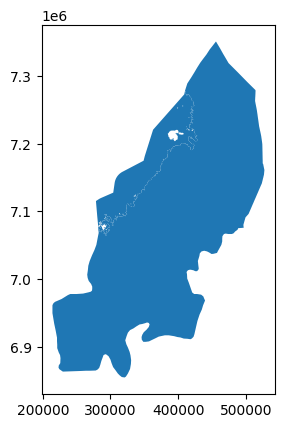

In [20]:
test_wfs = getWebVectorLayer(data_qgis,esri_feature,esri_name,esri_attributes)
print (test_wfs)

data_df_wfs = gpd.read_file(test_wfs[0].source())

data_df_wfs
data_df_wfs.plot()